# Apply the Goldstein filter to reduce InSAR phase noise

In [ ]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

import geopandas as gpd
from eodag import EODataAccessGateway
import rioxarray as riox
from eo_tools.S1.process import goldstein

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
log = logging.getLogger(__name__)

In [4]:
# change to your custom locations
data_dir = "/data/S1"

ids = [
 "S1A_IW_SLC__1SDV_20230904T063730_20230904T063757_050174_0609E3_DAA1", 
 "S1A_IW_SLC__1SDV_20230916T063730_20230916T063757_050349_060FCD_6814"
]
primary_dir = f"{data_dir}/{ids[0]}.zip"
secondary_dir = f"{data_dir}/{ids[1]}.zip"
outputs_prefix="/data/res/dev-goldstein"

## Download S-1 products

In [ ]:
# load a geometry
file_aoi = "../data/Morocco_AOI.geojson"
shp = gpd.read_file(file_aoi).geometry[0]

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": shp
}

results, _ = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
dag.download_all(to_dl, outputs_prefix="/data/S1/", extract=False)

## Pre-process InSAR pair

In [ ]:
from eo_tools.S1.process import prepare_insar

out_dir = prepare_insar(
    dir_prm=primary_dir,
    dir_sec=secondary_dir,
    outputs_prefix=outputs_prefix,
    aoi_name=None,
    shp=shp,
    pol="vv",
    subswaths=["IW1", "IW2", "IW3"],
    cal_type="beta",
    apply_fast_esd=True,
    dem_upsampling=1.8,
    dem_buffer_arc_sec=40,
    warp_kernel="bicubic",
)

## Apply processing chains: interferogram and Goldstein filter 

In [ ]:
from eo_tools.S1.process import interferogram
from eo_tools.S1.process import apply_to_patterns_for_pair, apply_to_patterns_for_single
from pathlib import Path
geo_dir = Path(out_dir).parent

# compute interferograms
apply_to_patterns_for_pair(
    interferogram,
    out_dir=out_dir,
    file_prm_prefix="slc_prm",
    file_sec_prefix="slc_sec",
    file_out_prefix="ifg0",
    multilook=[1,4]
)

# apply Goldstein filter
apply_to_patterns_for_single(
    goldstein,
    out_dir=out_dir,
    file_in_prefix="ifg0",
    file_out_prefix="ifg",
    alpha=0.5,
    overlap=14,
)

## Apply geocoding, merge and crop subswaths

In [ ]:
from eo_tools.S1.process import geocode_and_merge_iw
from pathlib import Path
geo_dir = Path(out_dir).parent
geocode_and_merge_iw(geo_dir, shp=shp, var_names=["ifg0", "ifg"], clip_to_shape=True)

## Visualize

### Original

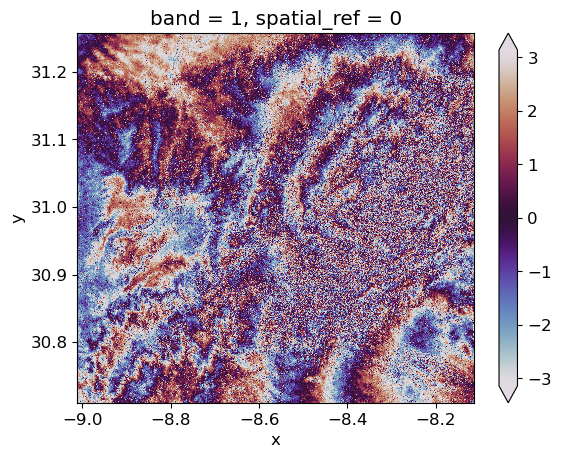

In [17]:
img0 = riox.open_rasterio(f"{geo_dir}/phi0_vv.tif")[0]
img0.plot.imshow(vmin=-3.14, vmax=3.14, interpolation="none", cmap="twilight")

### Filtered

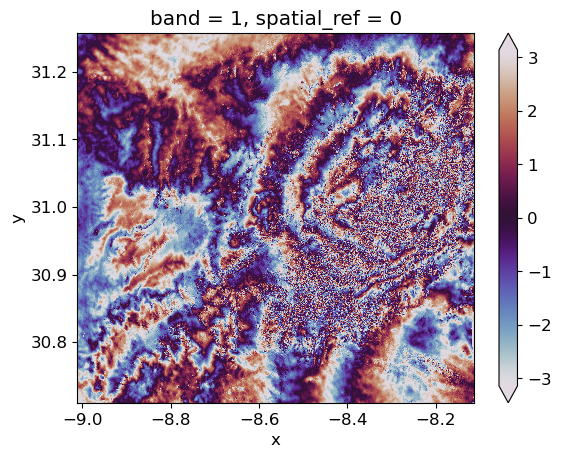

In [14]:
img = riox.open_rasterio(f"{geo_dir}/phi_vv.tif")[0]
img.plot.imshow(vmin=-3.14, vmax=3.14, interpolation='none', cmap="twilight")